In [32]:
import sys, os

sys.path += ["../../external/"]

In [33]:
%load_ext autoreload
%autoreload 1
%aimport zero_order_gpmpc
%aimport main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
from scipy.stats import norm
import casadi as cas
from acados_template import (
    AcadosOcp,
    AcadosSim,
    AcadosSimSolver,
    AcadosOcpSolver,
    AcadosOcpOptions,
)
import matplotlib.pyplot as plt
import torch
import gpytorch
import copy

# zoRO imports
import zero_order_gpmpc
from zero_order_gpmpc.controllers import (
    ZoroAcados,
    ZoroAcadosCustomUpdate,
    ZeroOrderGPMPC,
)
from inverted_pendulum_model_acados import (
    export_simplependulum_ode_model,
    export_ocp_nominal,
)
from utils import base_plot, add_plot_trajectory, EllipsoidTubeData2D

# gpytorch_utils
from gpytorch_utils.gp_hyperparam_training import (
    generate_train_inputs_acados,
    generate_train_outputs_at_inputs,
    train_gp_model,
)
from gpytorch_utils.gp_utils import (
    gp_data_from_model_and_path,
    gp_derivative_data_from_model_and_path,
    plot_gp_data,
    generate_grid_points,
)
from zero_order_gpmpc.models.gpytorch_models.gpytorch_gp import (
    BatchIndependentMultitaskGPModel,
)

## Define model parameters

We model the inverted pendulum

$$
\dot{x} = f(x,u) = \begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\sin(\theta) + u \end{bmatrix},
$$

which is to be controlled from the hanging-down resting position, $(\theta_0, \dot{\theta}_0) = (\pi, 0)$, to the upright position ($(\theta_r, \dot{\theta}_r) = (0,0)$), subject to the constraints that overshoot should be avoided, i.e.,

$$
\theta_{lb} \leq \theta \leq \theta_{ub}.
$$

The model setup and controller definition can be found in the functions `export_simplependulum_ode_model()`, `export_ocp_nominal()` in the `inverted_pendulum_model_acados.py` file.

In [35]:
# build C code again?
build_c_code = True

In [36]:
# discretization
N = 30
T = 5
dT = T / N

# constraints
x0 = np.array([np.pi, 0])
nx = 2
nu = 1

In [37]:
prob_x = 0.9
prob_tighten = norm.ppf(prob_x)

# noise
# uncertainty dynamics
sigma_theta = (0.0001 / 360.0) * 2 * np.pi
sigma_omega = (0.0001 / 360.0) * 2 * np.pi
w_theta = 0.03
w_omega = 0.03
Sigma_x0 = np.array([[sigma_theta**2, 0], [0, sigma_omega**2]])
Sigma_W = np.array([[w_theta**2, 0], [0, w_omega**2]])

## Set up nominal solver

In [38]:
from main import setup_ocp
ocp_init = setup_ocp(N, T)
acados_ocp_init_solver = AcadosOcpSolver(ocp_init, json_file="acados_ocp_init_simplependulum_ode.json")

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_simplependulum_ode.so
rm -f simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun.o acados_solver_simplependulum_ode.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/z

## Open-loop planning with nominal solver

In [39]:
# get initial values
X_init = np.zeros((N + 1, nx))
U_init = np.zeros((N, nu))

# xcurrent = x0
X_init[0, :] = x0

# solve
status_init = acados_ocp_init_solver.solve()

if status_init != 0:
    raise Exception(
        "acados acados_ocp_solver returned status {}. Exiting.".format(status_init)
    )

# get data
for i in range(N):
    X_init[i, :] = acados_ocp_init_solver.get(i, "x")
    U_init[i, :] = acados_ocp_init_solver.get(i, "u")

X_init[N, :] = acados_ocp_init_solver.get(N, "x")

In [40]:
import re

In [41]:
# integrator for nominal model
from main import setup_sim_from_ocp
sim = setup_sim_from_ocp(ocp_init)

acados_integrator = AcadosSimSolver(
    sim, json_file="acados_sim_" + sim.model.name + ".json"
)

Setting collocation_type to GAUSS_LEGENDRE
Setting ext_fun_compile_flags to -O2
Setting integrator_type to ERK
Setting sim_method_jac_reuse to 0
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode.o acados_sim_solver_simplependulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I

## Simulator object

To automatically discretize the model (and obtain sensitivities of the discrete-time model) within the zero-order implementation, we create the `AcadosSimSolver` object to pass to the solver.

In [43]:
# generate training data for GP with augmented model
# "real model"
# model_actual = export_simplependulum_ode_model(model_name = sim.model.name + "_actual", add_residual_dynamics=True)
# model_actual = export_simplependulum_ode_model(model_name = sim.model.name + "_actual", add_residual_dynamics=False)
model_actual = export_simplependulum_ode_model()
# model_actual.f_expl_expr = model_actual.f_expl_expr + cas.vertcat(
#     cas.DM(0), -0.5 * cas.sin((model_actual.x[0]) ** 2)
# )
model_actual.f_impl_expr = model_actual.xdot - model_actual.f_expl_expr
model_actual.name = model_actual.name + "_actual"

# acados integrator
# sim_actual = setup_sim_from_ocp(ocp_init)
# sim_actual.model = model_actual

sim_actual = AcadosSim()
sim_actual.model = model_actual
sim_actual.solver_options.integrator_type = "ERK"

# set prediction horizon
sim_actual.solver_options.T = dT
# sim_actual.solver_options.T = ocp_init.solver_options.Tsim
sim_actual.solver_options.newton_iter = ocp_init.solver_options.sim_method_newton_iter
sim_actual.solver_options.newton_tol = ocp_init.solver_options.sim_method_newton_tol
sim_actual.solver_options.num_stages = int(ocp_init.solver_options.sim_method_num_stages[0])
sim_actual.solver_options.num_steps = int(ocp_init.solver_options.sim_method_num_steps[0])

# acados_ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_actual = AcadosSimSolver(
    sim_actual, json_file="acados_sim_" + model_actual.name + ".json"
)

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_actual.o acados_sim_solver_simplependulum_ode_actual.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/ze

In [44]:
ocp_init.solver_options.Tsim

0.16666666666666666

In [45]:
dir(ocp_init.solver_options)

['Tsim',
 '_AcadosOcpOptions__Tsim',
 '_AcadosOcpOptions__alpha_min',
 '_AcadosOcpOptions__alpha_reduction',
 '_AcadosOcpOptions__as_rti_iter',
 '_AcadosOcpOptions__as_rti_level',
 '_AcadosOcpOptions__collocation_type',
 '_AcadosOcpOptions__cost_discretization',
 '_AcadosOcpOptions__custom_templates',
 '_AcadosOcpOptions__custom_update_copy',
 '_AcadosOcpOptions__custom_update_filename',
 '_AcadosOcpOptions__custom_update_header_filename',
 '_AcadosOcpOptions__eps_sufficient_descent',
 '_AcadosOcpOptions__exact_hess_constr',
 '_AcadosOcpOptions__exact_hess_cost',
 '_AcadosOcpOptions__exact_hess_dyn',
 '_AcadosOcpOptions__ext_cost_num_hess',
 '_AcadosOcpOptions__ext_fun_compile_flags',
 '_AcadosOcpOptions__fixed_hess',
 '_AcadosOcpOptions__full_step_dual',
 '_AcadosOcpOptions__globalization',
 '_AcadosOcpOptions__globalization_use_SOC',
 '_AcadosOcpOptions__hessian_approx',
 '_AcadosOcpOptions__hpipm_mode',
 '_AcadosOcpOptions__initialize_t_slacks',
 '_AcadosOcpOptions__integrator_type'

In [46]:
dir(sim.solver_options)

['T',
 '_AcadosSimOpts__Tsim',
 '_AcadosSimOpts__collocation_type',
 '_AcadosSimOpts__ext_fun_compile_flags',
 '_AcadosSimOpts__integrator_type',
 '_AcadosSimOpts__output_z',
 '_AcadosSimOpts__sens_adj',
 '_AcadosSimOpts__sens_algebraic',
 '_AcadosSimOpts__sens_forw',
 '_AcadosSimOpts__sens_hess',
 '_AcadosSimOpts__sim_method_jac_reuse',
 '_AcadosSimOpts__sim_method_newton_iter',
 '_AcadosSimOpts__sim_method_newton_tol',
 '_AcadosSimOpts__sim_method_num_stages',
 '_AcadosSimOpts__sim_method_num_steps',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'collocation_type',
 'ext_fun_compile_flags',
 'integrator_type',
 'newton_iter',
 'newton_tol',
 'num_

## Simulation results (nominal)

In [53]:
X_init_sim = np.zeros_like(X_init)
X_init_sim[0, :] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_init_sim[i, :])
    acados_integrator_actual.set("u", U_init[i, :])
    acados_integrator_actual.solve()
    X_init_sim[i + 1, :] = acados_integrator_actual.get("x")

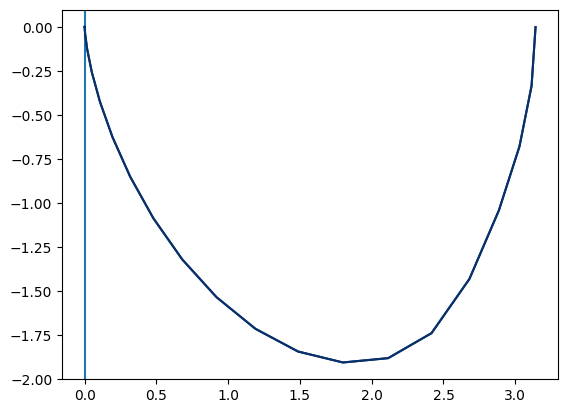

In [54]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_nom = EllipsoidTubeData2D(center_data=X_init, ellipsoid_data=None)
plot_data_nom_sim = EllipsoidTubeData2D(center_data=X_init_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)

# GP training

We use a model with different parameters to emulate the real-world model and obtain some training data. Also create simulator object for real-world model to evaluate our results later (not used in solver).

## Generate training data

We generate training data (one-step ahead residuals `y_train` for starting point `x_train`) here by running robustified (cautious) solver without GP.

In [55]:
random_seed = 123
N_sim_per_x0 = 1
N_x0 = 10
x0_rand_scale = 0.1

x_train, x0_arr = generate_train_inputs_acados(
    acados_ocp_init_solver,
    x0,
    N_sim_per_x0,
    N_x0,
    random_seed=random_seed,
    x0_rand_scale=x0_rand_scale,
)

y_train = generate_train_outputs_at_inputs(
    x_train, acados_integrator, acados_integrator_actual, Sigma_W
)

In [56]:
x_train

array([[ 3.18088649e+00, -4.27721330e-02, -2.00000000e+00],
       [ 3.14642964e+00, -3.71665627e-01, -2.00000000e+00],
       [ 3.05642391e+00, -7.10902620e-01, -2.00000000e+00],
       [ 2.90836978e+00, -1.06980940e+00, -2.00000000e+00],
       [ 2.69821910e+00, -1.45750358e+00, -1.27978873e+00],
       [ 2.43053846e+00, -1.76088578e+00, -7.37497144e-02],
       [ 2.12599280e+00, -1.89914580e+00,  7.89364821e-01],
       [ 1.80795754e+00, -1.92067418e+00,  1.38237953e+00],
       [ 1.49331414e+00, -1.85574059e+00,  1.75891077e+00],
       [ 1.19482113e+00, -1.72431980e+00,  1.95930011e+00],
       [ 9.22287533e-01, -1.54238945e+00,  1.99999981e+00],
       [ 6.82681878e-01, -1.32827323e+00,  1.95932910e+00],
       [ 4.80547268e-01, -1.09266952e+00,  1.81560487e+00],
       [ 3.17956221e-01, -8.54277557e-01,  1.60997551e+00],
       [ 1.94187901e-01, -6.27628225e-01,  1.36343680e+00],
       [ 1.06279859e-01, -4.24862299e-01,  1.09242294e+00],
       [ 4.94635843e-02, -2.55365164e-01

## Hyper-parameter training for GP model

Optimize hyper-parameters of GP model (kernel function parameters, ...)

In [57]:
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
nout = y_train.shape[1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=nout)
gp_model = BatchIndependentMultitaskGPModel(x_train_tensor, y_train_tensor, likelihood)

In [58]:
load_gp_model_from_state_dict = True
state_dict_path_gp_model = "gp_model_state_dict.pth"
state_dict_path_likelihood = "gp_model_likelihood_state_dict.pth"
train_data_path = "gp_model_train_data.pth"

if load_gp_model_from_state_dict:
    # Load state dict
    gp_model.load_state_dict(torch.load(state_dict_path_gp_model))
    likelihood.load_state_dict(torch.load(state_dict_path_likelihood))
else:
    training_iterations = 200
    rng_seed = 456

    gp_model, likelihood = train_gp_model(
        gp_model, torch_seed=rng_seed, training_iterations=training_iterations
    )

# EVAL MODE
gp_model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [59]:
# save GP hyper-params
torch.save(gp_model.state_dict(), state_dict_path_gp_model)
torch.save(likelihood.state_dict(), state_dict_path_likelihood)
torch.save({"x_train": x_train_tensor, "y_train": y_train_tensor}, train_data_path)

In [60]:
data_dict = torch.load(train_data_path)
data_dict

{'x_train': tensor([[ 3.1809e+00, -4.2772e-02, -2.0000e+00],
         [ 3.1464e+00, -3.7167e-01, -2.0000e+00],
         [ 3.0564e+00, -7.1090e-01, -2.0000e+00],
         [ 2.9084e+00, -1.0698e+00, -2.0000e+00],
         [ 2.6982e+00, -1.4575e+00, -1.2798e+00],
         [ 2.4305e+00, -1.7609e+00, -7.3750e-02],
         [ 2.1260e+00, -1.8991e+00,  7.8936e-01],
         [ 1.8080e+00, -1.9207e+00,  1.3824e+00],
         [ 1.4933e+00, -1.8557e+00,  1.7589e+00],
         [ 1.1948e+00, -1.7243e+00,  1.9593e+00],
         [ 9.2229e-01, -1.5424e+00,  2.0000e+00],
         [ 6.8268e-01, -1.3283e+00,  1.9593e+00],
         [ 4.8055e-01, -1.0927e+00,  1.8156e+00],
         [ 3.1796e-01, -8.5428e-01,  1.6100e+00],
         [ 1.9419e-01, -6.2763e-01,  1.3634e+00],
         [ 1.0628e-01, -4.2486e-01,  1.0924e+00],
         [ 4.9464e-02, -2.5537e-01,  8.0858e-01],
         [ 1.7619e-02, -1.2589e-01,  5.1917e-01],
         [ 3.6838e-03, -4.0942e-02,  2.2800e-01],
         [ 5.7767e-10, -3.1616e-03,  3.

## Plot GP predictions

We plot GP predictions along the predicted trajectory of the robustified solver by projecting the multivariate plot down to a line.

In [61]:
x_train.shape, y_train.shape

((300, 3), (300, 2))

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

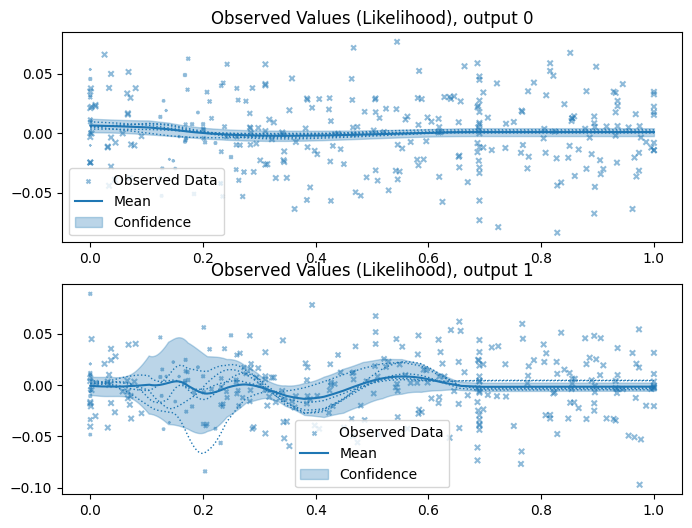

In [62]:
num_samples = 5
use_likelihood = False

num_points_between_samples = 30
t_lin = np.linspace(0, 1, num_points_between_samples, endpoint=False)

x_plot_waypts = np.hstack((X_init[1:, :], U_init))
x_plot = []
for i in range(x_plot_waypts.shape[0] - 1):
    x_plot += [
        x_plot_waypts[i, :] + (x_plot_waypts[i + 1, :] - x_plot_waypts[i, :]) * t
        for t in t_lin
    ]
x_plot = np.vstack(x_plot)

gp_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=num_samples, use_likelihood=use_likelihood
)
plot_gp_data([gp_data], marker_size_lim=[1, 15])

We can also plot the derivative of the GP. Note that the projected Jacobian is not smooth since our path is not smooth either (jump projection direction = jump in Jacobian); however, the actual Jacobian should be smooth here (squared exponential kernel).

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

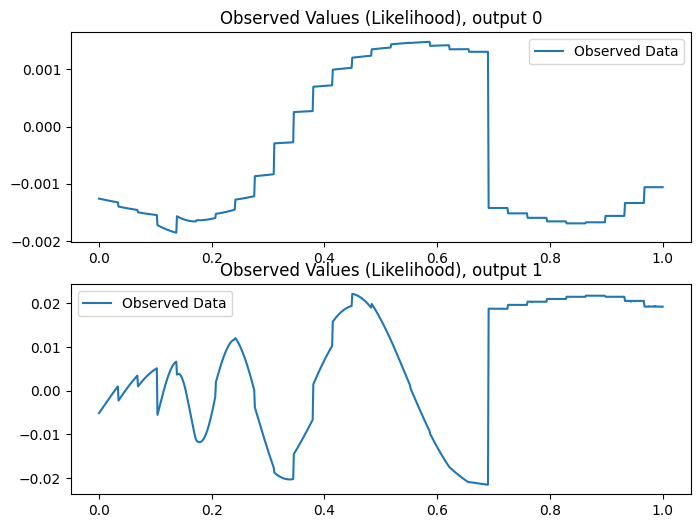

In [63]:
gp_derivative_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=0
)
plot_gp_data([gp_derivative_data], marker_size_lim=[5, 20], plot_train_data=False)

Compare with plotting along a slice of the dimension. Since we generated training data along the path of the robustified controller, the GP looks pretty untrained along a slice of the coordinates.

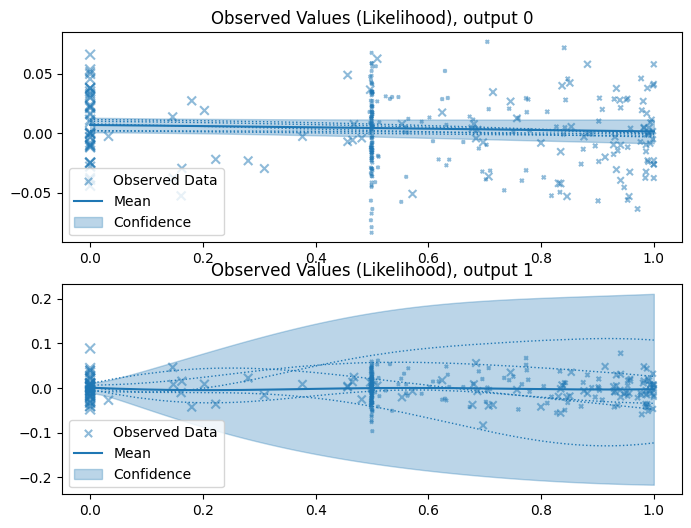

In [64]:
# plot along axis
x_dim_lims = np.array([[0, np.pi], [-2, 1], [-2, 2]])
x_dim_slice = np.array([1 * np.pi, 0, 0])
x_dim_plot = 2
x_grid = generate_grid_points(x_dim_lims, x_dim_slice, x_dim_plot, num_points=800)

gp_grid_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=num_samples, use_likelihood=use_likelihood
)
fig, ax = plot_gp_data([gp_grid_data], marker_size_lim=[5, 50])

y_lim_0 = ax[0].get_ylim()
y_lim_1 = ax[1].get_ylim()

Jacobian... not much going on away from the data points (this is good!)

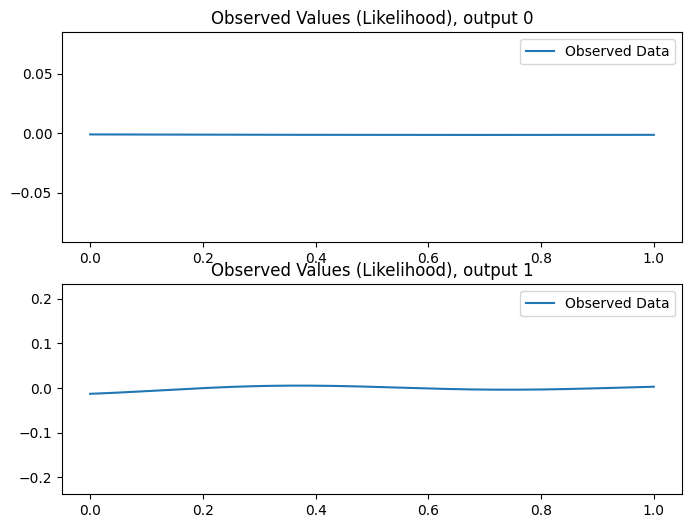

In [65]:
gp_derivative_grid_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=0
)
fig, ax = plot_gp_data(
    [gp_derivative_grid_data], marker_size_lim=[5, 50], plot_train_data=False
)

ax[0].set_ylim(*y_lim_0)
ax[1].set_ylim(*y_lim_1)
plt.draw()

# Residual-Model MPC

In [66]:
from zero_order_gpmpc.models.gpytorch_models.gpytorch_residual_model import (
    GPyTorchResidualModel,
)

In [67]:
residual_model = GPyTorchResidualModel(gp_model)

In [68]:
residual_model.evaluate(x_plot_waypts[0:3, :])

array([[ 0.00652427, -0.00064504],
       [ 0.00606629, -0.00132841],
       [ 0.00550909, -0.00100276]], dtype=float32)

In [69]:
residual_model.jacobian(x_plot_waypts[0:3, :])

array([[[ 0.00089437,  0.00107572, -0.00104834],
        [ 0.00091862,  0.00113921, -0.00106003],
        [ 0.00094876,  0.0011921 , -0.00107185]],

       [[ 0.02657048, -0.00123242, -0.01293994],
        [ 0.02428799, -0.00715194, -0.0118825 ],
        [ 0.02078021, -0.01205509, -0.00975332]]], dtype=float32)

In [70]:
residual_model.value_and_jacobian(x_plot_waypts[0:3, :])

(array([[ 0.00652427, -0.00064504],
        [ 0.00606629, -0.00132841],
        [ 0.00550909, -0.00100276]], dtype=float32),
 array([[[ 0.00089437,  0.00107572, -0.00104834],
         [ 0.00091862,  0.00113921, -0.00106003],
         [ 0.00094876,  0.0011921 , -0.00107185]],
 
        [[ 0.02657048, -0.00123242, -0.01293994],
         [ 0.02428799, -0.00715194, -0.0118825 ],
         [ 0.02078021, -0.01205509, -0.00975332]]], dtype=float32))

In [71]:
residual_mpc = ZeroOrderGPMPC(
    ocp_init,
    sim,
    prob_x,
    Sigma_x0,
    Sigma_W,
    h_tightening_idx=[0],
    gp_model=residual_model,
    use_cython=False,
    path_json_ocp="residual_mpc_ocp_solver_config.json",
    path_json_sim="residual_mpc_sim_solver_config.json",
    build_c_code=True,
)


The data of the generated custom update function consists of the concatenation of:
1) input: diag(P0)
2) input: diag(W)
3) input: concatenation of diag(W_gp^k) for i=0,...,N-1
4) output: concatenation of colmaj(P^k) for i=0,...,N


 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_linear_model_with_params_nx2_nu1_np0.so
rm -f linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun.o custom_update_function.o acados_solver_linear_model_with_params_nx2_nu1_np0.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-

In [72]:
for i in range(N):
    residual_mpc.ocp_solver.set(i, "x", X_init[i, :])
    residual_mpc.ocp_solver.set(i, "u", U_init[i, :])
residual_mpc.ocp_solver.set(N, "x", X_init[N, :])

residual_mpc.solve()
X_res, U_res = residual_mpc.get_solution()

initing 30 solve stat fields
residuals after  0 SQP_RTI iterations:
 [2.61799388e+00 1.17363138e-02 2.17935259e-01 5.84647303e-09]
residuals after  1 SQP_RTI iterations:
 [1.56534849e-02 4.39074562e-04 2.80228325e-02 8.95569022e-09]
residuals after  2 SQP_RTI iterations:
 [1.23941049e-03 1.19105488e-05 6.82973483e-03 8.82358816e-09]
residuals after  3 SQP_RTI iterations:
 [3.41295839e-04 6.05243286e-06 1.88957132e-03 8.83621787e-09]
residuals after  4 SQP_RTI iterations:
 [9.29135366e-05 3.36182656e-06 5.19246403e-04 8.83372581e-09]
residuals after  5 SQP_RTI iterations:
 [2.52813635e-05 4.48410262e-06 1.39172937e-04 8.83595996e-09]
residuals after  6 SQP_RTI iterations:
 [1.57658715e-05 4.28366298e-06 6.84441691e-05 8.83702695e-09]
residuals after  7 SQP_RTI iterations:
 [1.39347293e-05 4.47804863e-06 4.73754309e-05 8.83126654e-09]
residuals after  8 SQP_RTI iterations:
 [9.57734954e-06 7.18370551e-06 2.57551462e-05 8.83280586e-09]
residuals after  9 SQP_RTI iterations:
 [7.71080515e-

In [73]:
X_res_sim = np.zeros_like(X_res)
X_res_sim[0, :] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_res_sim[i, :])
    acados_integrator_actual.set("u", U_res[i, :])
    acados_integrator_actual.solve()
    X_res_sim[i + 1, :] = acados_integrator_actual.get("x")

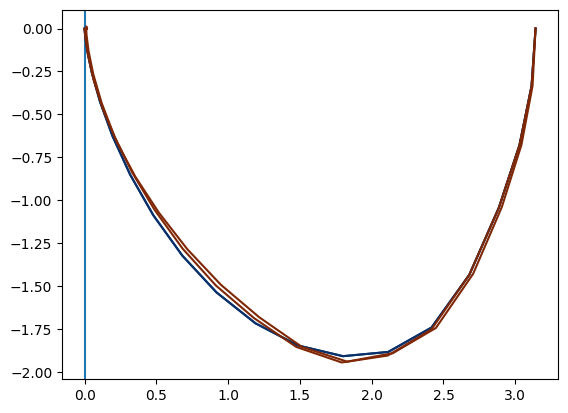

In [74]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_res = EllipsoidTubeData2D(center_data=X_res, ellipsoid_data=None)
plot_data_res_sim = EllipsoidTubeData2D(center_data=X_res_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_res, prob_tighten=None, color_fun=plt.cm.Oranges)
add_plot_trajectory(ax, plot_data_res_sim, prob_tighten=None, color_fun=plt.cm.Oranges)

# Zero-Order GP-MPC

We can add the GP model to the solver by simply adding it as an argument to the `ZoroAcados` function. Therefore we copy (important!) the robustified controller and then instantiate another solver object.

### Custom Update version

In [75]:
# delete c_generated_code folder to avoid reusing old files by accident...
import shutil

shutil.rmtree("c_generated_code")

In [76]:
# # we use both-sided bounds again, specify which bound to be tightened using according index
# ocp_cupdate = export_ocp_nominal(N,T,only_lower_bounds=False)
# we use one-sided bounds since we just want to tighten upper bound
ocp_cupdate = export_ocp_nominal(
    N, T, only_lower_bounds=True, model_name="simplependulum_ode_cupdate"
)

# tighten constraints
idh_tight = np.array([0])  # lower on theta (theta >= 0)

# integrator for nominal model
sim_cupdate = AcadosSim()

sim_cupdate.model = ocp_cupdate.model
sim_cupdate.parameter_values = ocp_cupdate.parameter_values
for opt_name in dir(ocp_cupdate.solver_options):
    if opt_name in dir(sim.solver_options) and re.search(r"__.*?__", opt_name) is None:
        set_value = getattr(ocp_cupdate.solver_options, opt_name)
        if opt_name == "sim_method_jac_reuse" and isinstance(set_value, list):
            set_value = int(set_value[0])

        print(f"Setting {opt_name} to {set_value}")
        setattr(sim.solver_options, opt_name, set_value)

# set prediction horizon
sim_cupdate.solver_options.T = dT

# acados_ocp_solver = AcadosOcpSolver(ocp_cupdate, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_cupdate = AcadosSimSolver(
    sim_cupdate, json_file="acados_sim_" + sim_cupdate.model.name + "_cupdate.json"
)

Setting collocation_type to GAUSS_LEGENDRE
Setting ext_fun_compile_flags to -O2
Setting integrator_type to ERK
Setting sim_method_jac_reuse to 0
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_cupdate.o acados_sim_solver_simplependulum_ode_cupdate.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/i

In [77]:
zoro_solver_cupdate = ZoroAcadosCustomUpdate(
    ocp_cupdate,
    sim_cupdate,
    prob_x,
    Sigma_x0,
    Sigma_W,
    h_tightening_idx=idh_tight,
    gp_model=gp_model,
    use_cython=False,
    path_json_ocp="zoro_ocp_solver_config_cupdate.json",
    path_json_sim="zoro_sim_solver_config_cupdate.json",
)

for i in range(N):
    zoro_solver_cupdate.ocp_solver.set(i, "x", X_init[i, :])
    zoro_solver_cupdate.ocp_solver.set(i, "u", U_init[i, :])
zoro_solver_cupdate.ocp_solver.set(N, "x", X_init[N, :])

zoro_solver_cupdate.solve()
X_cup, U_cup, P_cup = zoro_solver_cupdate.get_solution()


The data of the generated custom update function consists of the concatenation of:
1) input: P0; full matrix in column-major format


 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_linear_model_with_params_nx2_nu1_np0.so
rm -f linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun.o custom_update_function_gpzoro.o acados_solver_linear_model_with_params_nx2_nu1_np0.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-g

: 

### Custom update (with GP) vs. Residual GP -> the same!

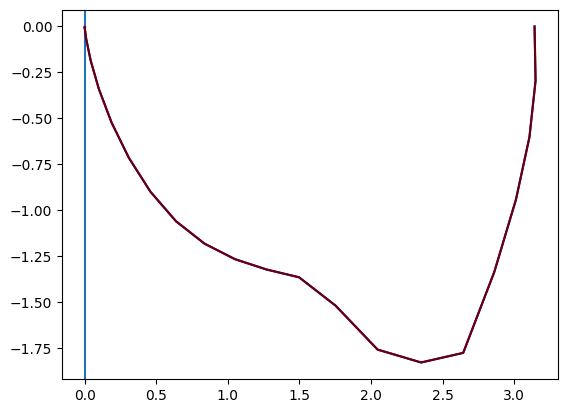

In [ ]:
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_gp_cupdate = EllipsoidTubeData2D(
    center_data=X_cup,
    # ellipsoid_data = np.array(P_cup)
    ellipsoid_data=None,
)
add_plot_trajectory(ax, plot_data_gp_cupdate, color_fun=plt.cm.Purples)
add_plot_trajectory(ax, plot_data_res, color_fun=plt.cm.Reds)

In [ ]:
zoro_solver_cupdate.print_solve_stats()

build_lin_model     :   17.279ms (30 calls),    0.576/   0.601/   0.561ms (avg/max/min per call)
query_nodes         :   27.677ms (30 calls),    0.923/   2.161/   0.686ms (avg/max/min per call)
get_gp_sensitivities:  405.651ms (30 calls),   13.522/ 123.686/   7.919ms (avg/max/min per call)
integrate_acados    :    0.583ms (30 calls),    0.019/   0.030/   0.012ms (avg/max/min per call)
integrate_acados_python:    3.943ms (30 calls),    0.131/   0.147/   0.124ms (avg/max/min per call)
integrate_get       :   36.573ms (30 calls),    1.219/   1.273/   1.184ms (avg/max/min per call)
integrate_set       :   44.450ms (30 calls),    1.482/   1.592/   1.428ms (avg/max/min per call)
set_sensitivities   :   17.290ms (30 calls),    0.576/   0.667/   0.545ms (avg/max/min per call)
set_sensitivities_reshape:    5.352ms (30 calls),    0.178/   0.227/   0.164ms (avg/max/min per call)
propagate_covar     :    0.000ms (30 calls),    0.000/   0.000/   0.000ms (avg/max/min per call)
get_backoffs        : 